In [65]:
#!/usr/bin/python
# -*- coding: utf8-*-
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.fft import fft, ifft
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
    


In [2]:
global_temp = pd.read_csv('../elena/Downloads/GlobalLandTemperatures/GlobalTemperatures.csv',index_col='dt', parse_dates=True)
global_temp_city = pd.read_csv('../elena/Downloads/GlobalLandTemperatures/GlobalLandTemperaturesByCity.csv',index_col='dt', parse_dates=True)
global_temp_country = pd.read_csv('../elena/Downloads/GlobalLandTemperatures/GlobalLandTemperaturesByCountry.csv',index_col='dt', parse_dates=True)

Анализируем погоду в период Второй Мировой войны, с 1939 по 1945 года. Пытаемся понять как война повлияла на климат.
10 самых жарких города в 1939 году

In [86]:
global_temp_city[global_temp_city.index.year == 1939][['City','Country','AverageTemperature']].groupby(['City','Country']).mean().sort('AverageTemperature',ascending=False).head()

,,AverageTemperature
City,Country,
Khartoum,Sudan,29.422500
Umm Durman,Sudan,29.422500
Niamey,Niger,29.196500
Jibuti,Djibouti,29.145583
Kassala,Sudan,29.108750


Если посмотреть на другие года, тот этот рейтинг немного меняется, но города Судана остаются одними из самых жарких 

In [89]:
global_temp_city[global_temp_city.index.year == 1945][['City','Country','AverageTemperature']].groupby(['City','Country']).mean().sort('AverageTemperature',ascending=False).head()

,,AverageTemperature
City,Country,
Jibuti,Djibouti,29.460500
Mopti,Mali,28.932417
Khartoum,Sudan,28.860000
Umm Durman,Sudan,28.860000
Kassala,Sudan,28.800500


А теперь посмотрим, в каких городах погода не радовала и вести военные действия было гораздо сложнее

In [93]:
global_temp_city[global_temp_city.index.year == 1939][['City','Country','AverageTemperature']].groupby(['City','Country']).mean().sort('AverageTemperature',ascending=True).head()

,,AverageTemperature
City,Country,
Norilsk,Russia,-10.249750
Kyzyl,Russia,-5.562083
Ulaanbaatar,Mongolia,-2.887583
Chita,Russia,-2.872750
Anchorage,United States,-2.683083


In [96]:
global_temp_city[global_temp_city.index.year == 1945][['City','Country','AverageTemperature']].groupby(['City','Country']).mean().sort('AverageTemperature',ascending=True).head()

,,AverageTemperature
City,Country,
Norilsk,Russia,-9.854167
Kyzyl,Russia,-6.286250
Chita,Russia,-4.242750
Nefteyugansk,Russia,-3.642917
Surgut,Russia,-3.642917


Как видим, в сибирских городах было заметно холоднее. 
Посмотрим на среднюю температуру Земли и окена в период 1939-1945. Характер графика циклический, и каких-то заметных отклонений от температурных норм не наблюдается. 

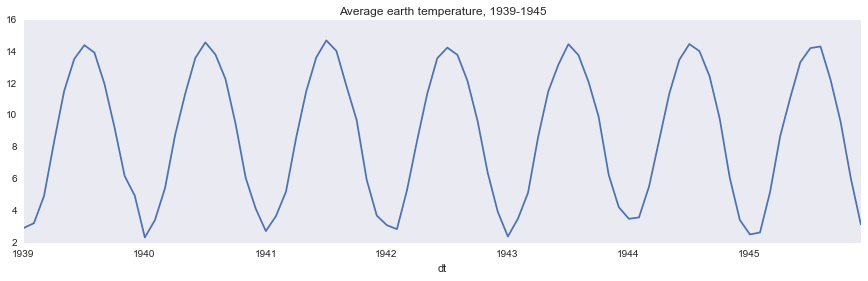

In [103]:
plt.figure(figsize=(15,4))
global_temp[(global_temp.index.year > 1938) & (global_temp.index.year < 1946)]['LandAverageTemperature'].plot()
plt.grid()
plt.title("Average earth temperature, 1939-1945")
plt.show()

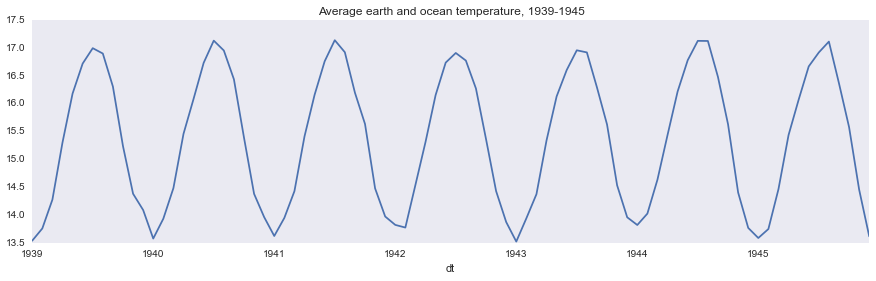

In [104]:
plt.figure(figsize=(15,4))
global_temp[(global_temp.index.year > 1938) & (global_temp.index.year < 1946)]['LandAndOceanAverageTemperature'].plot()
plt.grid()
plt.title("Average earth and ocean temperature, 1939-1945")
plt.show()

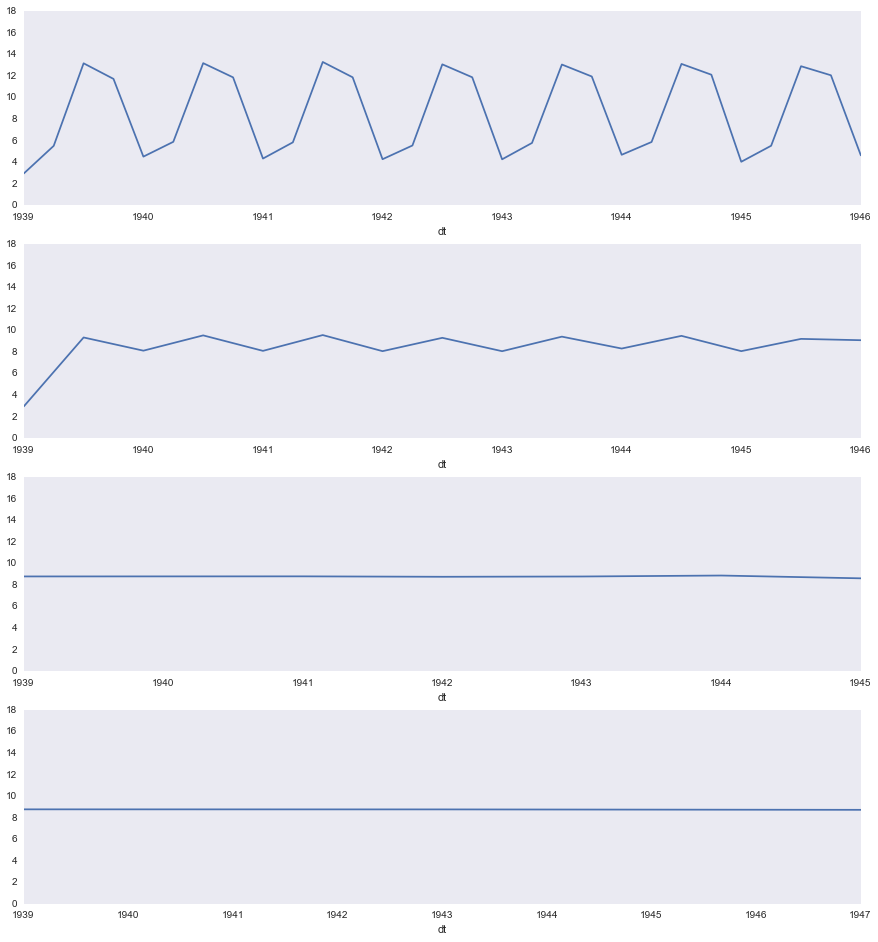

In [105]:

plt.figure(figsize=(15,16))

# Seasonal
seasonal_temp = global_temp[(global_temp.index.year > 1938) & (global_temp.index.year < 1946)].resample('3M', how='mean')
plt.subplot(4,1,1)
seasonal_temp['LandAverageTemperature'].plot()
plt.ylim([0,18])
plt.grid()

# half year
bi_seasonal_temp = global_temp[(global_temp.index.year > 1938) & (global_temp.index.year < 1946)].resample('6M', how='mean')
plt.subplot(4,1,2)
bi_seasonal_temp['LandAverageTemperature'].plot()
plt.ylim([0,18])
plt.grid()

# Yearly
year_temp = global_temp[(global_temp.index.year > 1938) & (global_temp.index.year < 1946)].resample('A', how='mean')
plt.subplot(4,1,3)
year_temp['LandAverageTemperature'].plot()
plt.ylim([0,18])
plt.grid()

# 4-Yearly
year_4_temp = global_temp[(global_temp.index.year > 1938) & (global_temp.index.year < 1946)].resample('4A', how='mean')
plt.subplot(4,1,4)
year_4_temp['LandAverageTemperature'].plot()
plt.ylim([0,18])
plt.grid()
plt.show()

Посмотрим на автокорреляцию - она подтверждает, что в наших данных присутствует цикличность.

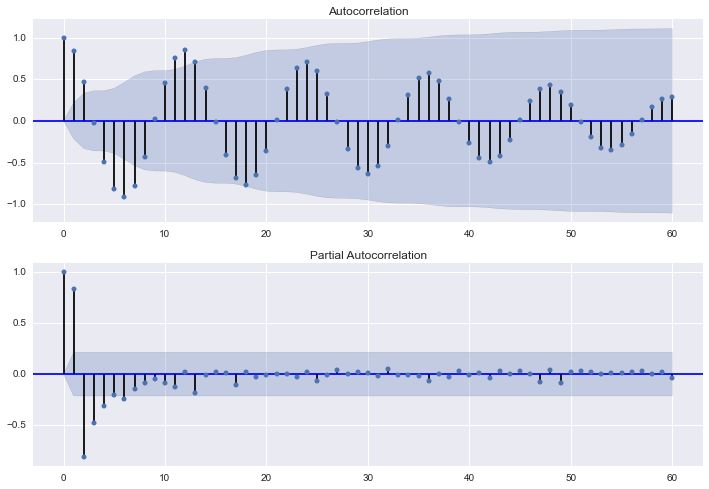

In [179]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(global_temp[(global_temp.index.year > 1938) & (global_temp.index.year < 1946)]['LandAverageTemperature'], lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(global_temp[(global_temp.index.year > 1938) & (global_temp.index.year < 1946)]['LandAverageTemperature'], lags=60, ax=ax2)

Проанализируем температуры в городах, у которых совпадают координаты широты или долготы. Возьмем Россию в военные годы

In [180]:
global_temp_city.Latitude.unique()

array(['57.05N', '40.99N', '50.63N', '44.20N', '42.59N', '5.63N', '29.74N',
       '53.84N', '49.03N', '7.23N', '18.48N', '36.17N', '32.95N', '24.92N',
       '8.84N', '16.87N', '21.70N', '45.81N', '34.56S', '13.66N', '20.09N',
       '7.23S', '15.27N', '39.38N', '23.31N', '26.52N', '31.35N', '34.56N',
       '37.78N', '12.05S', '26.52S', '36.17S', '28.13N', '52.24N',
       '55.45N', '47.42N', '0.80S', '4.02S', '12.05N', '23.31S', '16.87S',
       '61.88N', '18.48S', '20.09S', '21.70S', '10.45S', '24.92S',
       '65.09N', '4.02N', '13.66S', '10.45N', '39.38S', '2.41N', '8.84S',
       '5.63S', '58.66N', '60.27N', '32.95S', '0.80N', '15.27S', '29.74S',
       '28.13S', '2.41S', '44.20S', '45.81S', '31.35S', '37.78S', '42.59S',
       '40.99S', '68.31N', '69.92N', '52.24S', '63.49N'], dtype=object)

In [181]:
global_temp_city[global_temp_city.Country == 'Russia'][["City",'Country','Latitude']].groupby(['City','Latitude']).head()

,City,Country,Latitude
dt,,,
1820-08-01 00:00:00,Abakan,Russia,53.84N
1820-09-01 00:00:00,Abakan,Russia,53.84N
1820-10-01 00:00:00,Abakan,Russia,53.84N
1820-11-01 00:00:00,Abakan,Russia,53.84N
1820-12-01 00:00:00,Abakan,Russia,53.84N
1820-08-01 00:00:00,Achinsk,Russia,57.05N
1820-09-01 00:00:00,Achinsk,Russia,57.05N
1820-10-01 00:00:00,Achinsk,Russia,57.05N
1820-11-01 00:00:00,Achinsk,Russia,57.05N


Выберем три города - Жуковский, Альметьевск и Златоуст, они находяется на одной широте. Мы видим схожесть их температур, а в начале 1944 температура в Жуковском была заметно ниже, чем в Златоусте.

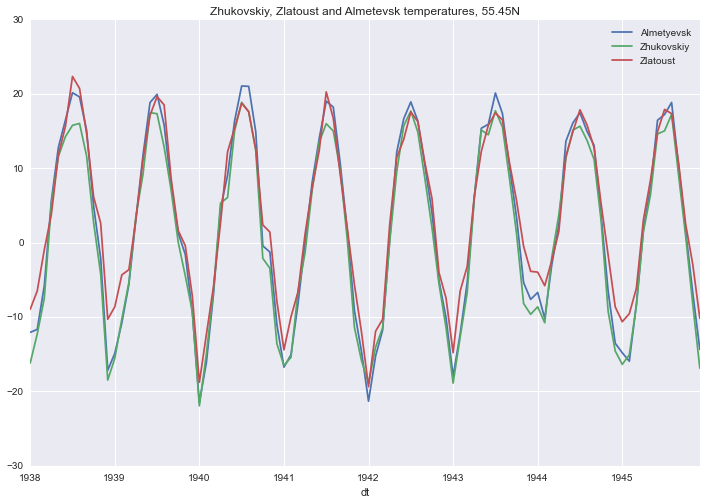

In [184]:
zhukovskiy = global_temp_city[(global_temp_city.Latitude == '55.45N') & (global_temp_city.City == "Zlatoust")]
zhukovskiy = zhukovskiy[(zhukovskiy.index.year >= 1938) & (zhukovskiy.index.year < 1946)]
almetyevsk = global_temp_city[(global_temp_city.Latitude == '55.45N') & (global_temp_city.City == "Almetyevsk")]
almetyevsk = almetyevsk[(almetyevsk.index.year >= 1938) & (almetyevsk.index.year < 1946)]

zlatoust = global_temp_city[(global_temp_city.Latitude == '55.45N') & (global_temp_city.City == "Zhukovskiy")]
zlatoust = zlatoust[(zlatoust.index.year >= 1938) & (zlatoust.index.year < 1946)]

plt.figure(figsize=(12,8))
almetyevsk.AverageTemperature.plot(label="Almetyevsk")
zhukovskiy.AverageTemperature.plot(label='Zhukovskiy')
zlatoust.AverageTemperature.plot(label = 'Zlatoust')
plt.title('Zhukovskiy, Zlatoust and Almetevsk temperatures, 55.45N')
plt.legend()

In [189]:
global_temp_city[global_temp_city.Country == 'Russia'][["City",'Country','Longitude']].groupby(['City','Longitude']).head()

,City,Country,Longitude
dt,,,
1820-08-01 00:00:00,Abakan,Russia,91.36E
1820-09-01 00:00:00,Abakan,Russia,91.36E
1820-10-01 00:00:00,Abakan,Russia,91.36E
1820-11-01 00:00:00,Abakan,Russia,91.36E
1820-12-01 00:00:00,Abakan,Russia,91.36E
1820-08-01 00:00:00,Achinsk,Russia,90.00E
1820-09-01 00:00:00,Achinsk,Russia,90.00E
1820-10-01 00:00:00,Achinsk,Russia,90.00E
1820-11-01 00:00:00,Achinsk,Russia,90.00E


Помсотрим на города Ачинск и Норильск, расположенные оба в Красноярском крае, но в противополжных частях края. Их долгота почти совпадает, но разница в температурах заметная - в Норильске климат субарктического типа и он по праву считается одним из холодных городов России. Температура зимой была ниже 30 градусов, тогда как в Ачинске тепмература опускалась только ниже 20 градусов. Кроме того, температурная кривая Норильска характеризиуется резкими пиками, что показывает характер климата.
Немцам тут бы точно не понравилось.

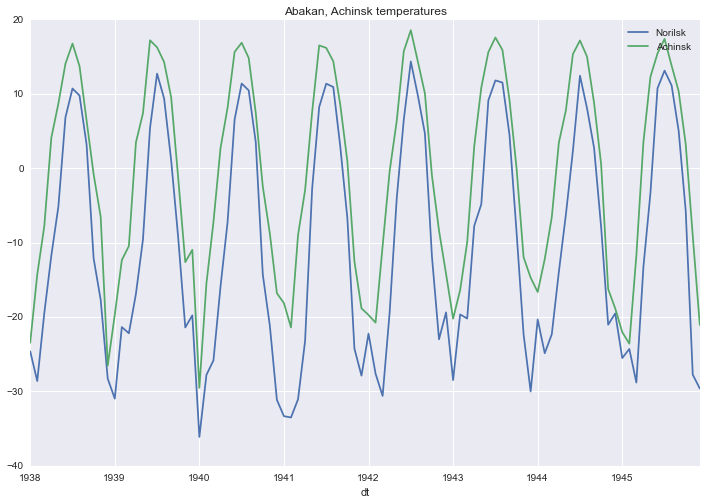

In [194]:
abakan = global_temp_city[(global_temp_city.City == "Norilsk")]
abakan = abakan[(abakan.index.year >= 1938) & (abakan.index.year < 1946)]
achinsk = global_temp_city[(global_temp_city.City == "Achinsk")]
achinsk = achinsk[(achinsk.index.year >= 1938) & (achinsk.index.year < 1946)]


plt.figure(figsize=(12,8))
abakan.AverageTemperature.plot(label="Norilsk")
achinsk.AverageTemperature.plot(label='Achinsk')
plt.title('Abakan, Achinsk temperatures')
plt.legend()